<a href="https://colab.research.google.com/github/tglanz/bsc/blob/master/2024b-22961/mmn15/mmn15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mmn15, 2024b 11961

Date: 17/06/2024

Author: Tal Glanzman

[Github](https://github.com/tglanz/bsc/blob/master/2024b-22961/mmn15/mmn15.ipynb)

[Youtube]()

In [3]:
import torch
import torchvision
import math
import heapq

from typing import Optional, Sequence, Tuple
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

import dataclasses
from tqdm import tqdm

# Q1

In this section we will implement a custom 2d convolutional layer forward pass.

In [ ]:
class Conv2d(torch.nn.Module):
    """ Our own implementation of 2d convolutional layer """
    def __init__(self,
                 in_channels: int = 1, out_channels: int = 1,
                 kernel_size: Tuple[int] = (1, 1),
                 stride: int = 1,
                 padding: int = 0):
        """
        Parameters:
          in_channels {int} Number of channels in the input tensor.

          out_channels {int} Number of channels in the output tensor.

          kernel_size {Tuple[int, int]} Kernel size in the form of (rows, cols).

          stride {int} The stride of the kernel indicates the step size by which the filter is moved along the input.
          This value indicates the step size in both the horizontal and vertical directions.

          padding {int} The amount of zeros to pad the input tensor before and after along each of it's spatial dimemsions.
        """
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # In reality, this should have been an `nn.Parameter`.
        # The question requirement said "don't use any nn functionality", so I didn't put it as a parameter,
        # hopefully I understood the requirements correctly.
        # Nonetheless, for the purposes of evaluation, which is what we do here, it doesn't really matter if
        # it's a parameter or not since we aren't optimizing.
        self.weight = self.create_kernel()

    def create_kernel(self) -> torch.Tensor:
        """
        Create and initialize a kernel tensor.
        The tensor is initialized using a method similar to Xavier.
        The values are sampled from a distribution that is dependant on the size of the kernel.

        Returns a tensor of size (self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1]).
        Intuitively, we can think of this tensor as {self.out_channels} filters,
        each having {self.in_channels} channels and of size {self.kernel_size}.
        """
        xavier = 1 / math.sqrt(torch.Size(self.kernel_size).numel())
        kernel = torch.rand(self.out_channels, self.in_channels, *self.kernel_size)
        return kernel.uniform_(-xavier, +xavier)

    def convolve(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform the 2d convolution of x with self.kernel.

        The kernel is comprised of multiple filters.

        Each filter is moved along the input according to {self.stride} and is reduced along the (c, h, w) dimensions.
        Each filter yields an output feature map, thus the result has {self.out_channels} channels.
        """
        stride = self.stride
        p = self.padding
        xb, xc, xh, xw = x.shape

        # Create a padded tensor by first creating a zero tensor and then embed x in the center.
        padded = torch.zeros(xb, xc, xh + 2*p, xw + 2*p)
        padded[:, :, p:(p + xh), p:(p + xw)] = x

        y_size = self.calculate_output_size(x)
        y = torch.empty(y_size)

        kernel = self.weight
        kh, kw = self.kernel_size

        # Traverse the (row=r, col=s) in the output spatial dimensions
        # and compute all neurons of different channels simultaneously,
        for r in range(y.shape[2]):
            for s in range(y.shape[3]):
                sub_x = padded[:, :, r*stride:r*stride+kh, s*stride:(s*stride+kw)]

                # This unsqueeze is important.
                # sub_x has shape (batch, in_channels, kernel_h, kernel_w)
                # kernel has shape (out_channels, in_channels, kernel_h, kernel_w)
                # By unsqueezine sub_x at dim 1 we enable the kernel and sub_x to be broadcastable together.
                # Then, the operation wil be performed for each batch and for each out channel.
                sub_x.unsqueeze_(1)

                mul = sub_x * kernel
                scalar = mul.sum(dim=(2, 3, 4))
                y[:, :, r, s] = scalar

        return y

    def calculate_output_size(self, x: torch.Tensor) -> Sequence[int]:
        """
        Calculates the size of the result of x convolve with self.kernel, it takes into consideration the padding and the stride.

        The computation, along some dimension, can be intuitively though of as this way:

        Let x, k, p and s be the input size, kernel size padding and stride respectively.

        The output size is given by
        $$
            \\frac{ (x + p) - (k + s) }{ s }
        $$

        - We add by (x + p) because it is the initial padded input size.
        - Then we subtract by (k + s) becase this is where the filter cannot reach due to its size and stride
        - Finally we divide by s becase we downsample the input due to the stride.

        This size is the same for eery batch and output channel.
        """
        batches = x.shape[0]
        xh, xw = x.shape[2], x.shape[3]

        kh, kw = self.kernel_size

        ph, pw = (2*self.padding for _ in range(2))
        sh, sw = self.stride, self.stride

        yh = (xh - kh + ph + sh) // sh
        yw = (xw - kw + pw + sw) // sw

        return (batches, self.out_channels, yh, yw)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.convolve(x)

In [ ]:
def test_convolution_layer():
    @dataclasses.dataclass
    class TestCase:
        batch: int
        in_channels: int
        out_channels: int
        input_size: Tuple[int, int]
        kernel_size: Tuple[int, int]
        stride: int
        padding: int

        print_tensors: bool = False

    test_cases = [
        TestCase(1, 1, 1, (4, 4), (2, 2), 1, 0, print_tensors=True),
        TestCase(2, 1, 1, (4, 4), (2, 2), 1, 0, print_tensors=True),
        TestCase(1, 3, 1, (4, 4), (2, 2), 1, 0, print_tensors=True),
        TestCase(1, 1, 2, (4, 4), (2, 2), 1, 0, print_tensors=True),
        TestCase(1, 1, 1, (4, 4), (2, 2), 2, 0, print_tensors=True),
        TestCase(2, 2, 2, (4, 4), (2, 2), 1, 2, print_tensors=False),
        TestCase(1, 1, 1, (1, 1), (1, 1), 2, 1, print_tensors=True),
        TestCase(10, 3, 2, (16, 16), (3, 3), 3, 2, print_tensors=False),
    ]

    for idx, test_case in enumerate(test_cases):
        print(f"####### Test Case {idx} #######", "\n")
        print("Parameters: ", dataclasses.asdict(test_case), "\n")
        batch, in_channels, out_channels, input_size, kernel_size, stride, padding, print_tensors = dataclasses.astuple(test_case)

        our_conv2d = Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)

        torch_conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        torch_conv2d.eval()
        torch_conv2d.weight = torch.nn.Parameter(our_conv2d.weight)

        x = torch.ones((batch, in_channels, *input_size))

        our_y = our_conv2d.forward(x)
        torch_y = torch_conv2d.forward(x)

        if not print_tensors:
            print("Skipping tensor print", "\n")
        else:
            print("Input: ", x, "\n")
            print("Kernel: ", our_conv2d.weight, "\n")
            print("Our output: ", our_y, "\n")
            print("Torch output: ", torch_y, "\n")

        same = torch.equal(our_y, torch_y)
        distance = torch.norm(our_y - torch_y).item()
        assert same or distance < 1e-5

test_convolution_layer()

####### Test Case 0 ####### 

Parameters:  {'batch': 1, 'in_channels': 1, 'out_channels': 1, 'input_size': (4, 4), 'kernel_size': (2, 2), 'stride': 1, 'padding': 0, 'print_tensors': True} 

Input:  tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]]) 

Kernel:  tensor([[[[ 0.0765, -0.3828],
          [ 0.1569,  0.3504]]]]) 

Our output:  tensor([[[[0.2010, 0.2010, 0.2010],
          [0.2010, 0.2010, 0.2010],
          [0.2010, 0.2010, 0.2010]]]]) 

Torch output:  tensor([[[[0.2010, 0.2010, 0.2010],
          [0.2010, 0.2010, 0.2010],
          [0.2010, 0.2010, 0.2010]]]], grad_fn=<ConvolutionBackward0>) 

####### Test Case 1 ####### 

Parameters:  {'batch': 2, 'in_channels': 1, 'out_channels': 1, 'input_size': (4, 4), 'kernel_size': (2, 2), 'stride': 1, 'padding': 0, 'print_tensors': True} 

Input:  tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]],


        [[[

# Q2


Denote

- $X \in \mathbb{F}^{3 \times 3} = (x_{i, j})$
- $K \in \mathbb{F}^{2 \times 1} = (k_{i, j})$

and $Y \in \mathbb{F}^{2 \times 3} = (y_{i, j})$ given by

$$
    X \ast K = Y
$$

Forall $r = 1, 2$ and $s = 1, 2, 3$ we calculate $y_{rs}$ b

$$
\begin{equation}
    y_{r, s} = x_{r, s} k_{1, 1} + x_{r+1, s} k_{2, 1}
\end{equation}
$$

Forall $i = 1, 2$, by the chain rule and (1) we get that

$$
    \frac{ \partial C }{ \partial k_{i, 1}} = \
    \sum_{r, s}\frac{ \partial C }{ \partial y_{r, s}} \frac{ \partial y_{r, s} }{ k_{i, 1 }} =\
    \sum_{r, s} \frac{ \partial C }{ \partial y_{r, s} } x_{r + i-1, s}
$$

Now we will notice that in (1), the derivative
${\frac{\partial y_{r, s}}{\partial x_{i,j}}}$
is non zero only when $j = s$ and $i \in \{ r, r+1\}$ (or the derivative itself result in 0). Therfore we get the followings:

Forall $i = 1$ and $j = 1, 2, 3$, by the chain rule and (1) we get that

$$
    \frac{ \partial C }{ \partial x_{i, j}} = \
    \sum_{r, s}\frac{ \partial C }{ \partial y_{r, s}} \frac{ \partial y_{r, s} }{ x_{i, j }} =\
    \frac {\partial C}{\partial y_{i, j}} k_{1, 1}
$$

Forall $i = 2, 3$ and $j = 1, 2, 3$, by the chain rule and (1) we get that

$$
    \frac{ \partial C }{ \partial x_{i, j}} = \
    \sum_{r, s}\frac{ \partial C }{ \partial y_{r, s}} \frac{ \partial y_{r, s} }{ x_{i, j }} =\
    \frac {\partial C}{\partial y_{i, j}} k_{1, 1} + \frac {\partial C}{\partial y_{i-1, j}} k_{2, 1}
$$

# Q3

In this section we will **re**-train a resnet18 model, which was pretrained on the [ImageNet](https://www.image-net.org/) dataset, on the [Cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

The way we gonna do it is by replacing the model's last layer. Originaly, the last layer is a fully connected layer whose output is of size 1,000 as the number of classes in the ImageNet. We will replace it with a different fully connected layer with output of size 10 as the number of classes in Cifar10.

Then, we will train only the replaced layer by optimizing only on its parameters while feeding the Cifar10 dataset.

In [4]:
IMAGENET_TRAINED_MEAN = torch.tensor([0.485, 0.456, 0.406])
IMAGENET_TRAINED_STD = torch.tensor([0.229, 0.224, 0.225])

def create_cifar_datasets():
    transform = torchvision.transforms.Compose([
        torchvision.transforms.PILToTensor(),
        torchvision.transforms.ConvertImageDtype(torch.float),
        torchvision.transforms.Resize(224),
        torchvision.transforms.Normalize(mean=IMAGENET_TRAINED_MEAN, std=IMAGENET_TRAINED_STD)
    ])

    train = torchvision.datasets.CIFAR10("datasets", train=True, download=True, transform=transform)
    test = torchvision.datasets.CIFAR10("datasets", train=False, download=True, transform=transform)

    return train, test

def plot_cifar_samples(cifar: torchvision.datasets.CIFAR10, samples_per_class: int = 3):

    plt.figure()

    class_counters = {
        cifar.class_to_idx[clazz]: 0
        for clazz
        in cifar.classes
    }

    fig, axes = plt.subplots(len(class_counters), samples_per_class, figsize=(12, 12))
    fig.tight_layout()

    # trained_std_tensor = torch.tensor(IMAGENET_TRAINED_STD).unsqueeze(1).unsqueeze(1)
    # trained_mean_tensor = torch.tensor(IMAGENET_TRAINED_MEAN).unsqueeze(1).unsqueeze(1)

    trained_std_tensor = IMAGENET_TRAINED_STD.unsqueeze(1).unsqueeze(1)
    trained_mean_tensor = IMAGENET_TRAINED_MEAN.unsqueeze(1).unsqueeze(1)

    for x, y in DataLoader(cifar):
        y = y.item()
        class_counter = class_counters[y]
        if class_counter < 3:
            grid_index = y * samples_per_class + class_counter
            axes = plt.subplot(len(class_counters), samples_per_class, grid_index + 1)
            axes.tick_params(which="both", size=0, labelsize=0)
            axes.set_title(cifar.classes[y])

            x = x.squeeze(0)
            x = x * trained_std_tensor + trained_mean_tensor
            x = x.permute(1, 2, 0)
            plt.imshow(x.numpy())
            class_counters[y] += 1

            # exit early without iterating the entire data set
            if sum(class_counters.values()) == samples_per_class * len(class_counters):
                break

def load_resnet() -> torchvision.models.ResNet:
    return torchvision.models.resnet18(pretrained=True)

def replace_head_and_prepare_from_training(
    model: torch.nn.Module,
    class_count: int = 10,
):
    # Turn off grad tracking of all paramaeters
    for parameter in model.parameters(recurse=True):
        parameter.requires_grad = False

    # Replace the fully connected layer with a new one to have the correct number of classes
    original_fc = model.fc
    model.fc = torch.nn.Linear(
        original_fc.in_features, class_count,
        bias=original_fc.bias is not None,
        device=original_fc.weight.device,
        dtype=original_fc.weight.dtype)

def train_model(
    model: torch.nn.Module,
    parameters: any,
    data: DataLoader,
    target_accuracy: float = 0.7,
    max_epochs: int = 4,
    device: Optional[torch.DeviceObjType] = None,
    batch_limit: Optional[int] = None,
):
    device = device or torch.device("cpu")

    batches = min(batch_limit or len(data), len(data))

    # Create the optimizer.
    optimizer = torch.optim.Adam(params=parameters, lr=0.001)

    # Loss function well suited for classification tasks
    loss_fn = torch.nn.CrossEntropyLoss()

    model.to(device)
    model.train(True)

    accuracy_per_batch = []

    epoch = 0
    while True:
        accuracy_per_batch.extend([0]*batches)

        for batch_index, batch in enumerate(tqdm(data, desc=f"Optimizing epoch {epoch}")):
            if batch_index >= batches:
                break

            xs, ys = batch
            xs = xs.to(device)
            ys = ys.to(device)

            optimizer.zero_grad()
            ys_model = model(xs)
            loss = loss_fn(ys_model, ys)
            loss.backward()
            optimizer.step()

            # Track the accuracies
            inferred_classes = torch.argmax(ys_model, dim=1)
            accuracy = (inferred_classes == ys).sum() / len(ys)
            accuracy_per_batch[epoch*batches + batch_index] = accuracy.item()

            progress = batch_index / batches

        epoch_mean_accuracy = torch.tensor(accuracy_per_batch[epoch*batches:(epoch+1)*batches]).mean().item()
        if epoch_mean_accuracy >= target_accuracy or epoch >= max_epochs - 1:
          break

        epoch += 1

    return accuracy_per_batch

def normal_density_function(tensor: torch.Tensor, sigma: torch.Tensor, mu: torch.Tensor) -> torch.Tensor:
    """ Computes the normal density function with parameters `sigma` and `mu` """
    a = sigma.mul(math.sqrt(2 * math.pi))
    b = torch.pow(((tensor - mu)/sigma), 2).mul(-1/2)
    return tensor.div(a).mul(torch.exp(b))

def plot_model_stats(training_accuracy_per_batch: Sequence[float], eval_normal_distribution: Tuple[torch.Tensor, torch.Tensor]):
  sigma2, mu = eval_normal_distribution

  fig = plt.figure()
  fig, ax = plt.subplots(1, 2)
  fig.suptitle(f"Model Stats")
  fig.tight_layout()

  ax = plt.subplot(1, 2, 1)
  plt.plot([acc * 100 for acc in training_accuracy_per_batch])
  ax = fig.axes[0]
  ax.set_title("Training accuracies")
  ax.set_xlabel("Batch")
  xticks = list(range(len(training_accuracy_per_batch)))
  ax.set_ylabel("Accuracy (%)")

  ax = plt.subplot(1, 2, 2)
  sigma = sigma2.sqrt()
  bell_x = torch.linspace(0, 1, 100)
  bell_y = normal_density_function(bell_x, sigma, mu)
  ax.set_title(f"Batch accuracy distribution (mean={mu*100:.2f}%)")
  ax.set_xlabel("Accuracy (%)")
  ax.set_ylabel("Density")
  plt.vlines([mu - 3 * sigma, mu + 3 * sigma], bell_y.min(), bell_y.max(), colors="r", linestyles="dotted")
  plt.plot(bell_x.numpy(), bell_y.numpy())

def plot_blunts(blunts, classes):
  if not blunts:
    return

  cols = min(len(blunts), 3)
  rows = min(len(blunts), (len(blunts) // cols) + 1)

  trained_std_tensor = IMAGENET_TRAINED_STD.unsqueeze(1).unsqueeze(1)
  trained_mean_tensor = IMAGENET_TRAINED_MEAN.unsqueeze(1).unsqueeze(1)

  fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
  fig.tight_layout()

  for idx, (value, y_model, x, y) in enumerate(blunts):
    real_class = classes[y]
    predicted_class = classes[y_model]

    axes = plt.subplot(rows, cols, idx + 1)
    axes.set_title(f"predicted={predicted_class} / actual={real_class}")

    axes.tick_params(which="both", size=0, labelsize=0)

    x = x.cpu().squeeze(0)
    x = x * trained_std_tensor + trained_mean_tensor
    x = x.permute(1, 2, 0)

    plt.imshow(x.cpu().numpy())


def evaluate_model(
    model: torch.nn.Module,
    data: DataLoader,
    device: Optional[torch.device] = None,
    batch_limit: Optional[int] = None,
    blunt_count: int = 10,
) -> Tuple[torch.Tensor, torch.Tensor]:
  if not device:
    device = torch.device("cpu")

  batches = min(batch_limit or len(data), len(data))
  accuracy_per_batch = [0]*batches

  blunt_heap = []

  with torch.no_grad():
    model.eval()
    model.to(device)

    for batch_index, batch in enumerate(tqdm(data, desc="Evaluating model")):
      if batch_index >= batches:
        break

      xs, ys = batch
      xs = xs.to(device)
      ys = ys.to(device)

      ys_model = model(xs)
      inferred_classes = torch.argmax(ys_model, dim=1)
      accuracy = (inferred_classes == ys).sum() / len(ys)
      accuracy_per_batch[batch_index] = accuracy

      # Althouth we put it in a heap, we can only calculate the topk in this batch
      # since bootom(n-k) will surely not be topk overall.
      wrong_classes_mask = inferred_classes != ys
      prediction_values, _ = torch.max(ys_model, dim=1)
      wrong_prediction_values = prediction_values[wrong_classes_mask]
      top_wrong_values, top_wrong_indices = wrong_prediction_values.topk(min(blunt_count, wrong_prediction_values.shape[0]))
      top_wrong_ys_model = torch.argmax(ys_model[wrong_classes_mask][top_wrong_indices], dim=1)
      top_wrong_xs = xs[wrong_classes_mask][top_wrong_indices]
      top_wrong_ys = ys[wrong_classes_mask][top_wrong_indices]
      for i in range(top_wrong_xs.shape[0]):
        y_model = top_wrong_ys_model[i]
        top_wrong_value = top_wrong_values[i]
        y = top_wrong_ys[i]
        x = top_wrong_xs[i,]

        if len(blunt_heap) == blunt_count:
          heapq.heappushpop(blunt_heap, (top_wrong_value, y_model, x, y))
        else:
          heapq.heappush(blunt_heap, (top_wrong_value, y_model, x, y))

  return torch.var_mean(torch.tensor(accuracy_per_batch)), blunt_heap

In [10]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Chosen device for execution: ", device)

Chosen device for execution:  cuda:0


100%|██████████| 170498071/170498071 [00:12<00:00, 13138513.58it/s]


Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified


<Figure size 640x480 with 0 Axes>

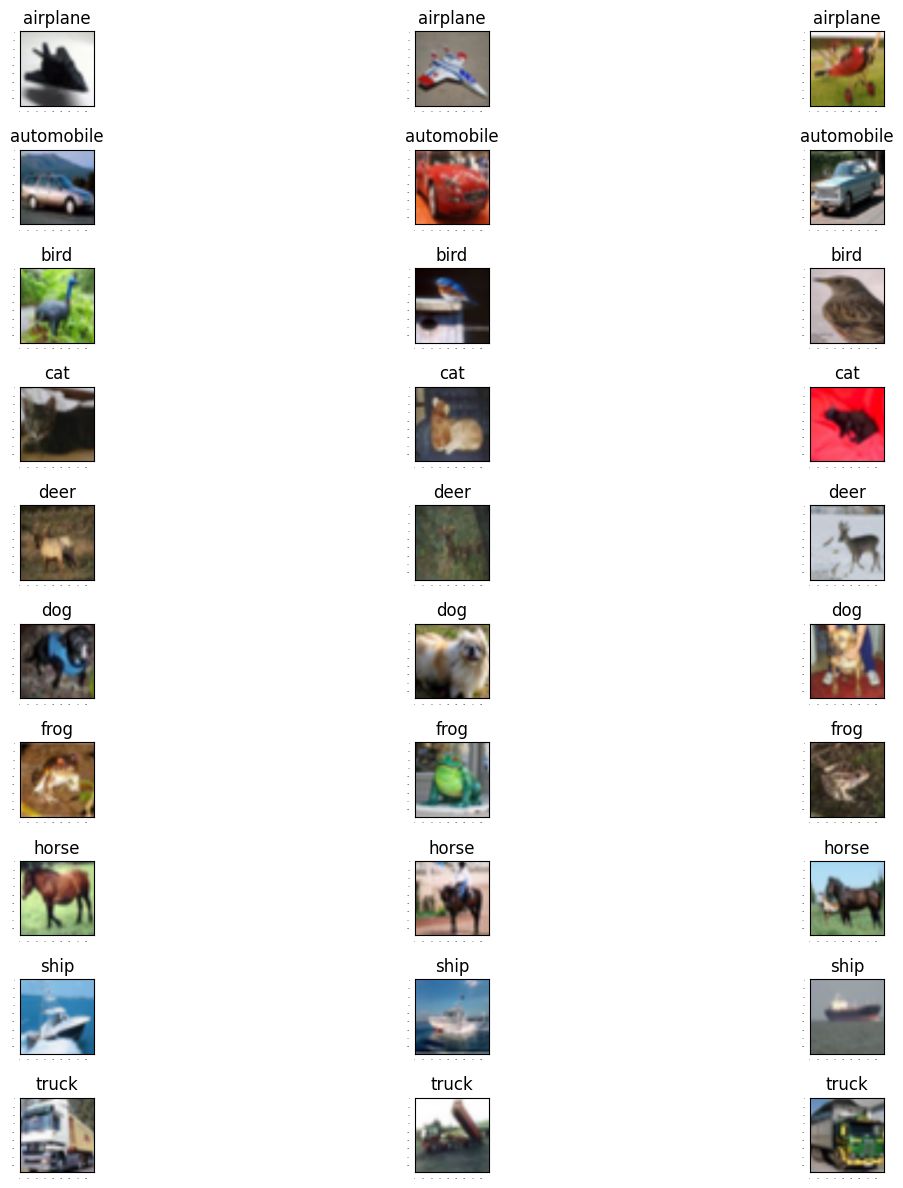

In [8]:
train_ds, test_ds = create_cifar_datasets()
plot_cifar_samples(train_ds)

In [ ]:
resnet = load_resnet()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
replace_head_and_prepare_from_training(resnet, class_count=len(train_ds.classes))

training_accuracy_per_batch = train_model(
    resnet,
    resnet.fc.parameters(),
    DataLoader(train_ds, shuffle=True, batch_size=256, num_workers=2, pin_memory=True),
    target_accuracy=0.7,
    device=device,
    max_epochs=4)

Optimizing epoch 1: 100%|██████████| 196/196 [01:47<00:00,  1.83it/s]


In [ ]:
eval_accuracy_distribution, blunts = evaluate_model(
    resnet,
    DataLoader(test_ds, shuffle=True, batch_size=256, pin_memory=True),
    device=device,
    blunt_count=10,
)

Evaluating model: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


<Figure size 640x480 with 0 Axes>

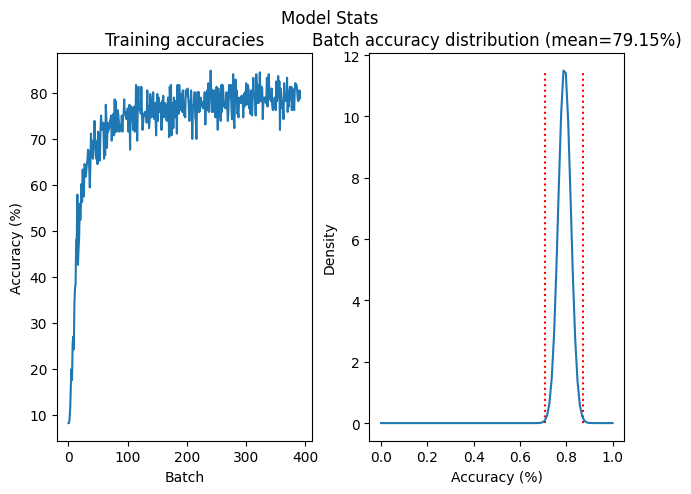

In [ ]:
plot_model_stats(training_accuracy_per_batch, eval_accuracy_distribution)

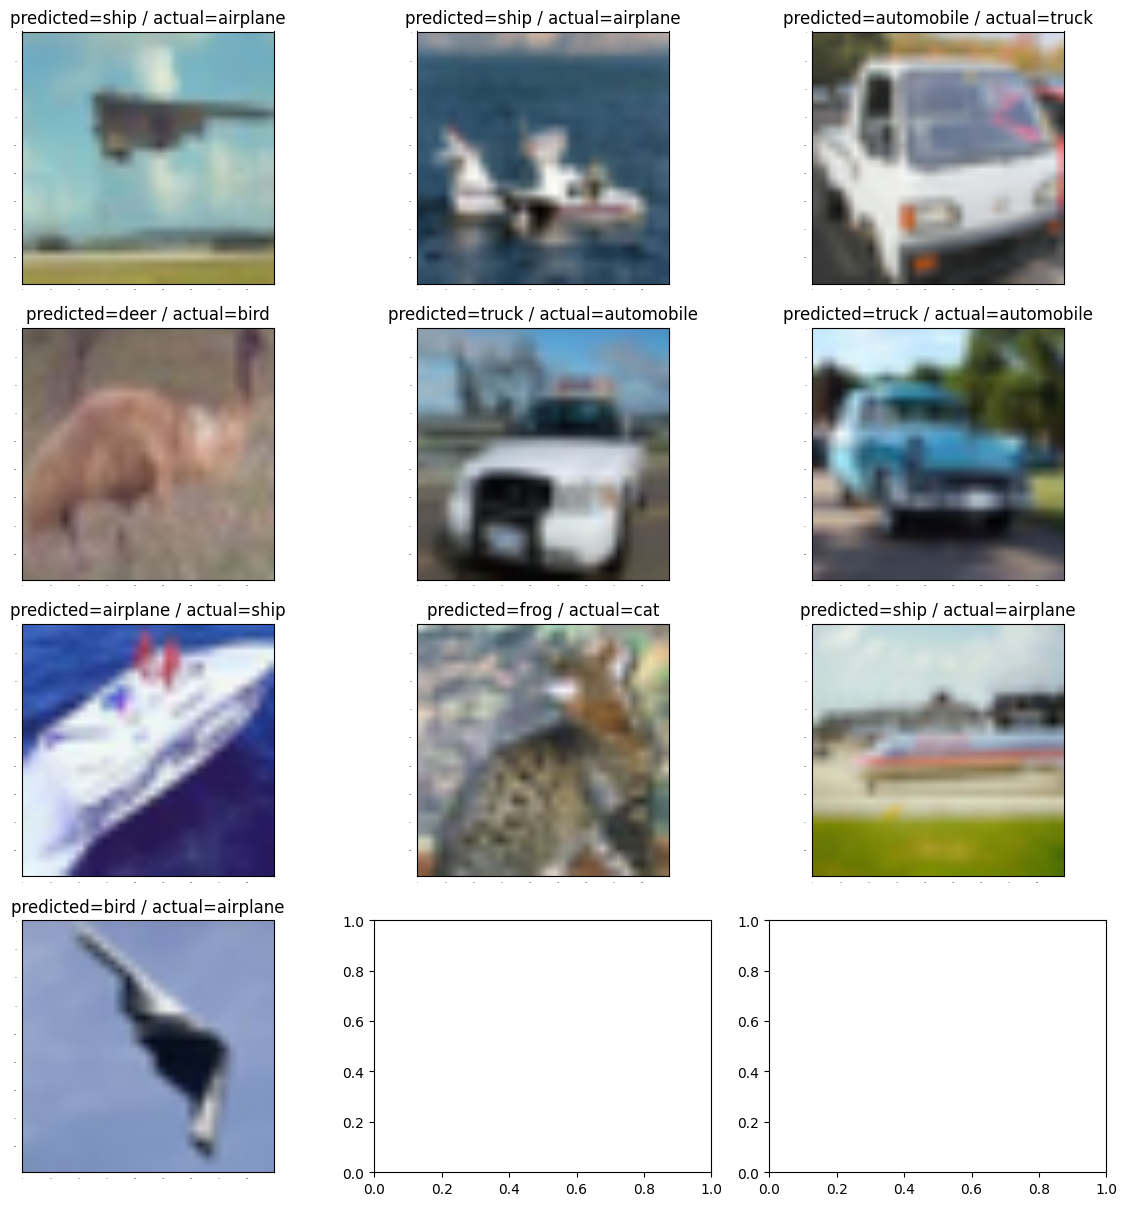

In [ ]:
plot_blunts(blunts, test_ds.classes)

In [25]:
class ResidualBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.upper_lane = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1),
        torch.nn.BatchNorm2d(out_channels)
    )

    self.conv3 = torch.nn.Conv2d(in_channels, out_channels, 1, stride=2)
    self.relu = torch.nn.ReLU(inplace=True)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    upper = self.upper_lane(x)
    lower = self.conv3(x)
    return self.relu(upper + lower)

class OurResnet(torch.nn.Module):
  def __init__(self, num_features):
    super().__init__()

    self.layers = torch.nn.Sequential(
        ResidualBlock(3, 64, (3, 3)),
        ResidualBlock(64, 128, (3, 3)),
        ResidualBlock(128, 256, (3, 3)),
        torch.nn.AdaptiveAvgPool2d((1, 1)),
        torch.nn.Flatten(),
        torch.nn.Linear(256, num_features)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layers(x)

In [26]:
our_resnet = OurResnet(len(train_ds.classes))

In [27]:
training_accuracy_per_batch = train_model(
    our_resnet,
    our_resnet.parameters(),
    DataLoader(train_ds, shuffle=True, batch_size=256, num_workers=2, pin_memory=True),
    target_accuracy=0.7,
    device=device,
    max_epochs=10)

Optimizing epoch 7: 100%|██████████| 196/196 [02:52<00:00,  1.14it/s]


In [28]:
eval_accuracy_distribution, blunts = evaluate_model(
    our_resnet,
    DataLoader(test_ds, shuffle=True, batch_size=256, pin_memory=True),
    device=device,
    blunt_count=10,
)

Evaluating model: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


<Figure size 640x480 with 0 Axes>

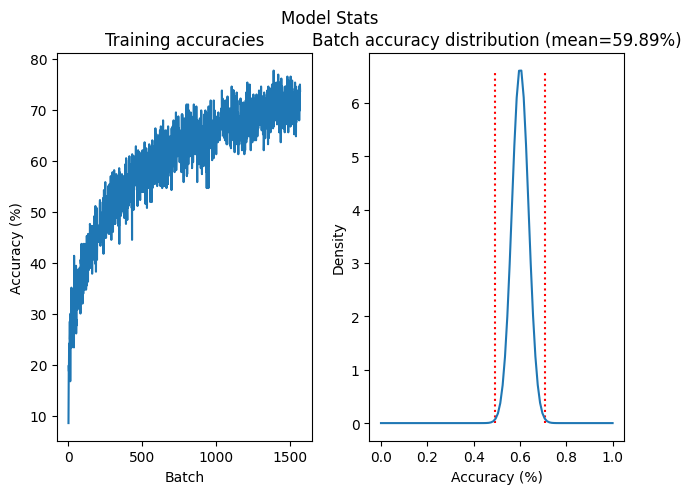

In [30]:
plot_model_stats(training_accuracy_per_batch, eval_accuracy_distribution)

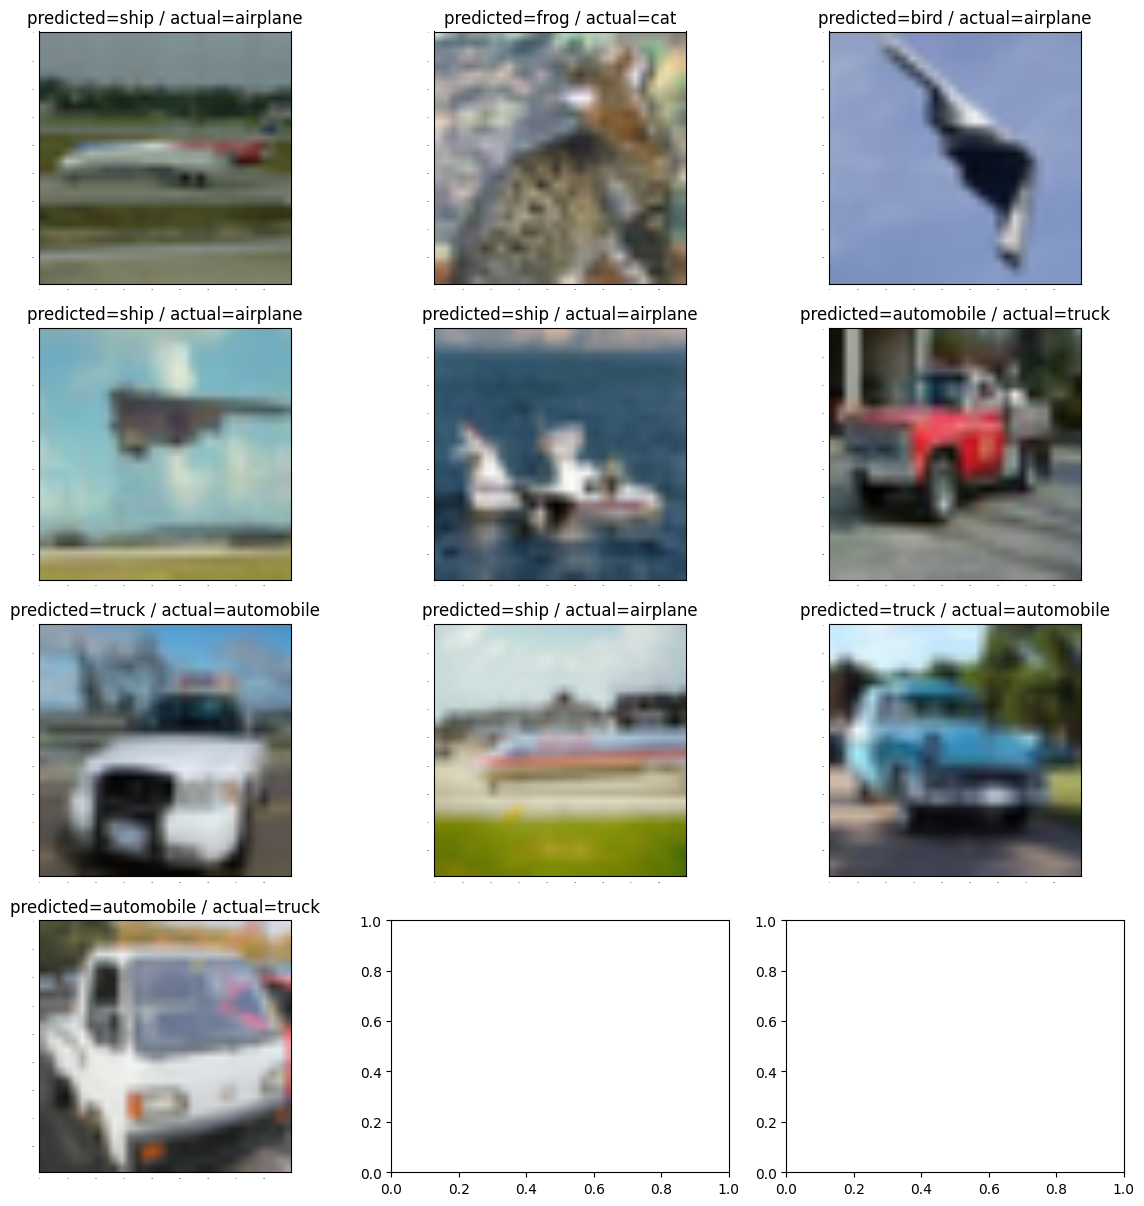

In [ ]:
plot_blunts(blunts, test_ds.classes)

# Preferencing between modified and standard Resnet

**Training Time / Computation**. Using the modified model we were able to reduce the learning times and computation resources. This is due to the fact that we needed to only compute the gradients and optimizer the modified layer, not the entire network.

**Performance**. Training our own architecture perform much worst than the modified one.

**Knowledge Sharing**. We were able to rely on the fact that the original network was trained on a dataset (ImageNet) we don't hold and potentially much larger or of higher quality than ours (Cifar10).

**Reinventing the wheel**. Using transfer learning, I didn't have to create my own architecture.

From the above bullets, my preference is to **use transfer learning when relevant**.

I don't suggest that it is always preferable though but only when it makes sense. Scenarios where it might not make sense
1. The original dataset is not related to our dataset and/or use case.
1. The original architecture of the network is what we want to apply to our use case. For example, CNNs for large context NLP tasks.
1. The original architecture resources is within our constraints. For example, we might want to deploy the network in embedded systems where the memory of the model is costly - We won't necesseraly want to transfer learning from a huge overparametrized network.
1. The original architecture utilizes our resources well. In opposite to (3), if we do have the capacity to run large architectures, we won't want to run small architectures intended for constrained systems.